In [8]:
#!pip3 install -r requirements.txt

In [3]:
import sys
import os
sys.path.insert(0, os.getcwd()+"/Utils")
sys.path.insert(0, os.getcwd()+"/Models")

In [4]:
#reload(ImageGeneration)
#reload(mask_functions)
#reload(Unet2D)
import random
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imshow
import Unet2D
import mask_functions
import getNucleusSegmentationData
import ImageGeneration
from img_utils import generate_subimages
from keras.models import Model, load_model
import Augmentor
import shutil
import tensorflow as tf

from importlib import reload


Using TensorFlow backend.


### Tensorboard setup
Use tensorboard to watch the progress. This is optional. If you want to see the results start tensorboard via command 'tensorboard --logdir=logs'. Expand and run the cell to enable tensorboard callback

In [5]:
import mask_functions
import ImageGeneration
from PIL import Image
from io import BytesIO
import base64
import keras
import numpy as np

def make_image(imagebg,imagefg):
    """
    Convert an numpy representation image to Image protobuf.
    Copied from https://github.com/lanpa/tensorboard-pytorch/
    """
    from PIL import Image
    height, width = imagebg.shape
    
    imagefg_mask = Image.fromarray(imagefg)
    imagebg = Image.fromarray(imagebg)

    
    red = Image.new('RGBA',imagebg.size,(255,0,0,125))
    
    
    image = Image.new("RGBA", imagebg.size)
    image.paste(imagebg)
    image.paste(red, (0, 0), imagefg_mask)

    
    import io
    output = io.BytesIO()
    image.save(output, format='PNG')
    image_string = output.getvalue()
    output.close()
    return tf.Summary.Image(height=height,
                         width=width,
                         colorspace=1,
                         encoded_image_string=image_string)
def colorize_model_output(model_inputs, img_array):
    full_color_dict = model_inputs['mask_color_dict']
    selected_keys = model_inputs['category_labels']
    color_dict = dict((i,full_color_dict[i]) for i in selected_keys if i in full_color_dict)
    ytrain = img_array.reshape(
        model_inputs['image_height'],
        model_inputs['image_width'],
        model_inputs['categories'])

    mask_dict = dict((i,ytrain[:,:,idx]==255) for idx,i in enumerate(selected_keys))

    color_img = mask_functions.colorize_mask_dict(mask_dict,color_dict)
    return color_img

def get_model_inputs():
    model_inputs = {
      "layer_count": 5,
      "starting_filter_count": 16,
      "convolution_dict": {
         "kernel_initializer": "he_normal",
         "activation": "relu",
         "kernel_size": (3, 3),
         "padding": "same",
        },
      "dropout_weight": 0.5,
      "pooling_dims": (2, 2),
      "stride_dims": (2, 2),
      "output_activation": "softmax",
      "image_height": 256,
      "image_width": 256,
      "input_channels": 1,
      "categories": 2,
      "mask_color_dict": mask_functions.original_color_dict(),
      "category_labels": ['background','nucleus'],
      "model_optimizer": "adam",
      "loss_function": "categorical_crossentropy",
      "validation_split": 0.1,
      "epochs": 50,
      "batch_size": 16,
      "filename": 'Unet2D-trained.h5',
      "stop_after": 10,
      "image_count": 10000,
      "image_directory": os.path.join(os.getcwd(), 'Training', 'Approved_Raw_Images'),
      "overwrite_images": False,
      "ground_truth_directory": os.path.join(os.getcwd(), 'Training', 'Approved'),
      "training_directory": os.path.join(os.getcwd(), 'Training', 'Approved_Raw_Images', 'output'),
      "test_split": 0.2
    }
    return model_inputs

class TensorBoardImage(keras.callbacks.Callback):
    def __init__(self, tag, ):
        self.histogram_freq=0
        self.write_graph=True
        self.write_images=True
        super().__init__() 
        self.tag = tag

        

  
    def on_epoch_end(self, epoch, logs={}):
        # Load image
        if epoch>1:
            params = get_model_inputs()
            filename = params['filename']
            directory_path = params['training_directory']
            filenames = os.listdir(directory_path)
            X_filenames = [os.path.join(directory_path,name) for name in filenames if name.startswith('Approved')]
            Y_filenames = [os.path.join(directory_path,name) for name in filenames if name.startswith('_groundtruth_')]

            X_filenames = X_filenames[0:99]
            Y_filenames = Y_filenames[0:99]
            X_files, Y_files = ImageGeneration.load_generated_images(X_filenames, Y_filenames, params)
            X_tr, X_te, Y_tr, Y_te = ImageGeneration.test_train_split(X_files, Y_files, params)
        
            best_model = load_model(params['filename'])
            predict = best_model.predict(X_tr)
            imbg = np.squeeze(X_tr[15])
            imfg = predict[15]
            imfg_mask = imfg.reshape(256,256,2)[:,:,1]
            imfg_mask_bool = ((imfg_mask>np.mean(imfg_mask))*255).astype('uint8')
            #imfg = predict[15].reshape(256,256,2)[:,:,1]
            #imfg = colorize_model_output(params,predict[19])

            image = make_image(imbg,imfg_mask_bool)
            summary = tf.Summary(value=[tf.Summary.Value(tag=self.tag, image=image)])
            writer = tf.summary.FileWriter('./logs')
            writer.add_summary(summary, epoch)
            writer.close()
        return

tbi_callback = TensorBoardImage('Image Example')

In [7]:
#tb=TensorBoardImage('Image Example')
#tb.on_epoch_end(6)

## Global model variables are defined here

In [8]:
model_inputs = {
      "layer_count": 5,
      "starting_filter_count": 16,
      "convolution_dict": {
         "kernel_initializer": "he_normal",
         "activation": "relu",
         "kernel_size": (3, 3),
         "padding": "same",
        },
      "dropout_weight": 0,
      "pooling_dims": (2, 2),
      "stride_dims": (2, 2),
      "output_activation": "softmax",
      "image_height": 256,
      "image_width": 256,
      "input_channels": 1,
      "categories": 2,
      "category_labels": ['background','nucleus'],
      "mask_color_dict": mask_functions.original_color_dict(),
      "model_optimizer": "adam",
      "loss_function": 'categorical_crossentropy',
      "validation_split": 0.1,
      "epochs": 50,
      "batch_size": 16,
      "filename": 'Unet2D-trained.h5',
      "stop_after": 10,
      "image_count": 10000,
      "image_directory": os.path.join(os.getcwd(), 'Training', 'Approved_Raw_Images'),
      "overwrite_images": False,
      "ground_truth_directory": os.path.join(os.getcwd(), 'Training', 'Approved'),
      "training_directory": os.path.join(os.getcwd(), 'Training', 'Approved_Raw_Images', 'output'),
      "test_split": 0.2,
      "tb_callback": TensorBoardImage('Image Train 15v2'),
      "learning_rate": 0.004
    }

## Get Training Image Data

Training data variables are defined with the rest of the model variables in model_inputs dict above

**Training Data Variables**
 - image_directory: Where approved training inputs are stored
 - training_directory: temporary directory where augmented data is stored
 - ground_truth_directory: directory where approved masks are stored
 - image_count: Number of augmented images to generate
 - test_split: % of images to be reserved for testing
 - overwrite_images: Set to True to regenerate augmented data. If false, program attempts to reuse the generated data. Useful for troubleshooting.


## Augment training dataset

In [ ]:
#X_train, X_test, Y_train, Y_test = ImageGeneration.get_data(model_inputs)

In [146]:
# load images from directory (ground truth, not generated images)
X_filenames = [fn for fn in os.listdir(model_inputs['image_directory']) if fn.startswith('SemImage')]
Y_filenames = [fn for fn in os.listdir(model_inputs['ground_truth_directory']) if fn.startswith('SemImage')]
X_filepaths = [os.path.join(model_inputs['image_directory'],name) for name in X_filenames]
Y_filepaths = [os.path.join(model_inputs['ground_truth_directory'],name) for name in Y_filenames]

def get_slice_info():
    from collections import namedtuple
    Slice = namedtuple('Slice', 'z id_num image mask')
    slices = [0 for ind in range(len(X_filenames))]
    for ind, fn in enumerate(X_filenames):
        z = np.uint32(fn[8:11]) # really janky, just pulls the 3-digit z-stack ID by removing first 8 characters
        id_num = fn.split('_')[1].split('.png')[0] # pulls the mTurk ID, e.g., 'L7504'
        image = ImageGeneration.read_image(X_filepaths[ind])
        mask = ImageGeneration.read_image(Y_filepaths[ind])
        slices[ind] = Slice(z, id_num, image, mask)

    slice_info = {
        'z':[slc.z for slc in slices],
        'id_num':[slc.id_num for slc in slices],
        'image':[slc.image for slc in slices],
        'mask':[slc.mask for slc in slices]
    }
    
    return(slices, slice_info)

(slices, slice_info) = get_slice_info()

In [165]:

slice_idx = 50
current_z = slices[slice_idx].z

closest_z_found_so_far = np.max(slices[slice_idx].z) # initialize
for z, ind in enumerate(slice_info['z']): # find the next slice above the current one
    print(z)
    print(closest_z_found_so_far)
    if ((z < closest_z_found_so_far) and (z > current_z)):
        print('true')
        next_larger_z_found_so_far = z

    


0
86
1
86
2
86
3
86
4
86
5
86
6
86
7
86
8
86
9
86
10
86
11
86
12
86
13
86
14
86
15
86
16
86
17
86
18
86
19
86
20
86
21
86
22
86
23
86
24
86
25
86
26
86
27
86
28
86
29
86
30
86
31
86
32
86
33
86
34
86
35
86
36
86
37
86
38
86
39
86
40
86
41
86
42
86
43
86
44
86
45
86
46
86
47
86
48
86
49
86
50
86
51
86
52
86
53
86
54
86
55
86
56
86
57
86
58
86
59
86
60
86
61
86
62
86
63
86
64
86
65
86
66
86
67
86
68
86
69
86
70
86
71
86
72
86
73
86
74
86
75
86
76
86
77
86
78
86
79
86
80
86
81
86
82
86
83
86
84
86
85
86
86
86
87
86
88
86
89
86
90
86
91
86
92
86
93
86
94
86
95
86
96
86
97
86
98
86
99
86
100
86
101
86
102
86
103
86
104
86
105
86
106
86
107
86
108
86
109
86
110
86
111
86
112
86
113
86
114
86
115
86
116
86
117
86
118
86
119
86
120
86
121
86
122
86
123
86
124
86
125
86
126
86
127
86
128
86


In [2]:
qtconsole

### Plot some images to qualitatively test our data augmentation and mask functions

In [10]:
def colorize_model_output(model_inputs, img_array):
    full_color_dict = model_inputs['mask_color_dict']
    selected_keys = model_inputs['category_labels']
    color_dict = dict((i,full_color_dict[i]) for i in selected_keys if i in full_color_dict)
    print(color_dict)
    ytrain = img_array.reshape(
        model_inputs['image_height'],
        model_inputs['image_width'],
        model_inputs['categories'])

    mask_dict = dict((i,ytrain[:,:,idx]==255) for idx,i in enumerate(selected_keys))

    color_img = mask_functions.colorize_mask_dict(mask_dict,color_dict,model_inputs['categories'])
    return color_img


NameError: name 'X_train' is not defined

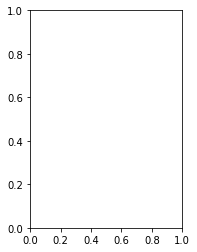

In [11]:
import random
img_id = 15
#random.randint(0,X_test.shape[0]-1)
plt.subplot(1,2,1)
xtrain0 = imshow(np.squeeze(X_train[img_id]))
plt.title('X Train')

plt.subplot(1,2,2)
ytrain0 = Y_train[img_id].reshape(256,256,2)
imshow(np.squeeze(ytrain0)[:,:,1])
plt.title('Y Train')

img_id


In [12]:
qtconsole

In [125]:
np.max(ytrain0)

255

## Define and Train Model

In [148]:
model = Unet2D.definemodel(model_inputs)

In [11]:
#model.summary()

In [149]:
model, results = Unet2D.trainmodel(X_train, Y_train, model, model_inputs)

Train on 7200 samples, validate on 800 samples
Epoch 1/50
7200/7200 [==============================] - 142s 20ms/step - loss: 131.3748 - categorical_accuracy: 0.8397 - val_loss: 123.2047 - val_categorical_accuracy: 0.8482

Epoch 00001: val_loss improved from inf to 123.20469, saving model to Unet2D-trained.h5
Epoch 2/50
7200/7200 [==============================] - 134s 19ms/step - loss: 114.2591 - categorical_accuracy: 0.8689 - val_loss: 888.1872 - val_categorical_accuracy: 0.4837

Epoch 00002: val_loss did not improve from 123.20469
Epoch 3/50
7200/7200 [==============================] - 144s 20ms/step - loss: 44.4204 - categorical_accuracy: 0.9219 - val_loss: 41.7129 - val_categorical_accuracy: 0.9252

Epoch 00003: val_loss improved from 123.20469 to 41.71286, saving model to Unet2D-trained.h5
Epoch 4/50
7200/7200 [==============================] - 127s 18ms/step - loss: 36.6386 - categorical_accuracy: 0.9339 - val_loss: 48.6499 - val_categorical_accuracy: 0.9160

Epoch 00004: val_lo

## Get Unlabeled Test Data

In [12]:
#help(generate_subimages)
#x_test = generate_subimages('Data/sem_image.PNG',128,20)

## Make predictions on test data based on best model

In [150]:
best_model = load_model(model_inputs['filename'])
predict = best_model.predict(X_test)

In [151]:
num_predict = predict.shape[0]
predict = predict.reshape(num_predict,256,256,2)

In [ ]:
### Generate predicted image for quantification

In [109]:
predict.shape

(2000, 256, 256, 2)

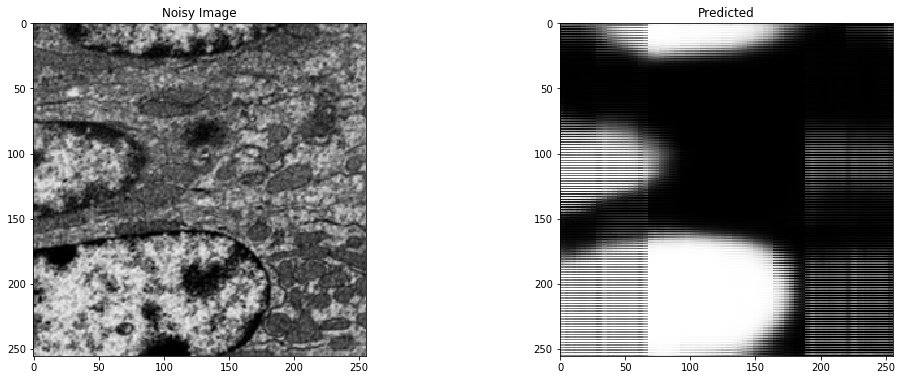

In [152]:
idx = 15
plt.subplot(1,2,1)
imshow(np.squeeze(X_test[idx]))
plt.title('Noisy Image')
plt.subplot(1,2,2)
gray = predict[idx].reshape(256,256,2)
imshow(gray[:,:,1])
plt.title('Predicted')
#plt.subplot(1,3,3)
#imshow(np.squeeze(y_train[idx,:,:]))
#plt.title('Ground Truth')
fig = plt.gcf()
fig.set_size_inches(15, 5)

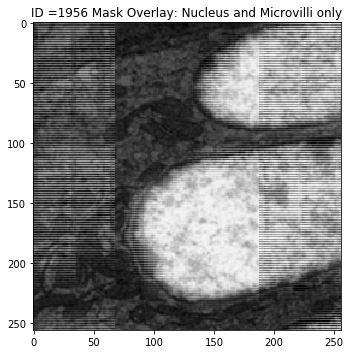

In [153]:
idx =  random.randint(0,X_test.shape[0])
imshow(np.squeeze(X_test[idx]))
gray = predict[idx].reshape(256,256,2)
imshow(gray[:,:,1],alpha=0.6)
plt.title('ID ='+str(idx)+' Mask Overlay: Nucleus and Microvilli only')
#plt.subplot(1,3,3)
#imshow(np.squeeze(y_train[idx,:,:]))
#plt.title('Ground Truth')
fig = plt.gcf()
fig.set_size_inches(15, 5)

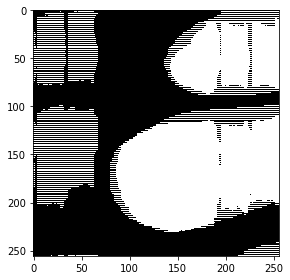

In [154]:
imshow(predict[idx][:,:,1]>np.mean(predict[idx][:,:,1]))